# Import libraries

In [ ]:
!pip install pyspark

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

# Set up spark session

In [ ]:
spark = SparkSession.builder.appName('RFM Segmentation').getOrCreate()

# Load dataset

In [ ]:
rfm_data = spark.read.csv('./online_retail_listing.csv',\
                            header = True,
                            sep = ';',
                            inferSchema = True)
rfm_data.show(5)
rfm_data.printSchema()

+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|1.12.2009 07:45| 6,95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|1.12.2009 07:45| 6,75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|1.12.2009 07:45| 6,75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|1.12.2009 07:45|  2,1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|1.12.2009 07:45| 1,25|      13085|United Kingdom|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
only showing top 5 rows

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)

In [ ]:
print(f'Rows and Column in dataframe: {rfm_data.toPandas().shape}')

Rows and Column in dataframe: (1048575, 8)


# Data Cleaning
Check and remove null values


In [ ]:
def check_null(data):
    data.agg(*[F.count(c).alias(c)
             for c in data.columns]).show()

check_null(rfm_data)

+-------+---------+-----------+--------+-----------+-------+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|  Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-------+-----------+-------+
|1048575|  1048575|    1044203| 1048575|    1048575|1048575|     811893|1048575|
+-------+---------+-----------+--------+-----------+-------+-----------+-------+



As we can see there are different counts for different columns which suggests there are lot of missing values in **Customer ID** column as the missing customer ID is a unique number of each customer that carry out a transaction and since this is missing we do not know which of the customer becoming irrelevant in the given scenario.

In [ ]:
online_data = rfm_data.dropna(how = 'any')
check_null(rfm_data)

+-------+---------+-----------+--------+-----------+-------+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|  Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-------+-----------+-------+
|1048575|  1048575|    1044203| 1048575|    1048575|1048575|     811893|1048575|
+-------+---------+-----------+--------+-----------+-------+-----------+-------+



In the transactions table, **Invoice** column starting from 'C' signifies cancellation, so all cancelled transactions will be dropped from the dataframe as it is not useful in this course.

In [ ]:
rfm_data = rfm_data.filter(~F.col('Invoice').contains('C'))
rfm_data.show(5)

+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|1.12.2009 07:45| 6,95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|1.12.2009 07:45| 6,75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|1.12.2009 07:45| 6,75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|1.12.2009 07:45|  2,1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|1.12.2009 07:45| 1,25|      13085|United Kingdom|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
only showing top 5 rows



Number of rows remaining after dropping cancelled transaction

In [ ]:
print(rfm_data.toPandas().shape)

(1029314, 8)


To rectify or restructure the irregular entry in the datatype for **Price** and **InvoiceDate** column to float and timestamp respectively, there is need to correst their values i.e  **'.'**,  instead of  **','** in price column and  **'_'**  instead of  **'.'** in invoice date column.

In [ ]:
def make_float(value):
    """function to replace ',' with '.' in price column to float data type."""
    updated_str = value.replace(',', '.')
    updated_float = float(updated_str)
    return updated_float

make_float_udf = F.udf(lambda value: float(str(value.replace(',', '.'))), FloatType())

rfm_data = rfm_data.withColumn('Price', make_float_udf(F.col("Price")))
rfm_data.show(5)

+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|1.12.2009 07:45| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|1.12.2009 07:45| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|1.12.2009 07:45| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|1.12.2009 07:45|  2.1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|1.12.2009 07:45| 1.25|      13085|United Kingdom|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+
only showing top 5 rows



In [ ]:
# Total price
rfm_data = rfm_data.withColumn('TotalPrice', F.round(rfm_data.Price * rfm_data.Quantity, 2))
rfm_data.show(5)

+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+----------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|       Country|TotalPrice|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+----------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|1.12.2009 07:45| 6.95|      13085|United Kingdom|      83.4|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|1.12.2009 07:45| 6.75|      13085|United Kingdom|      81.0|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|1.12.2009 07:45| 6.75|      13085|United Kingdom|      81.0|
| 489434|    22041|"RECORD FRAME 7""...|      48|1.12.2009 07:45|  2.1|      13085|United Kingdom|     100.8|
| 489434|    21232|STRAWBERRY CERAMI...|      24|1.12.2009 07:45| 1.25|      13085|United Kingdom|      30.0|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+----------+
only showi

Dealing with time column

In [ ]:
def make_time(value):
    """function to change InvoiceDate to time data type"""
    updated_time = pd.to_datetime(value, format = '%d.%m.%Y %H:%M')
    return  updated_time

## create a pyspark udf for InvoiceDate
make_time_udf = F.udf(lambda value: pd.to_datetime(value, format = '%d.%m.%Y %H:%M'), TimestampType())

rfm_data = rfm_data.withColumn('InvoiceDate', make_time_udf(F.col("InvoiceDate")))
rfm_data.show(5)

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+----------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|TotalPrice|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+----------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|      13085|United Kingdom|      83.4|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|      81.0|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|      81.0|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|      13085|United Kingdom|     100.8|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|      13085|United Kingdom|      30.0|
+-------+---------+--------------------+--------+-------------------+-----+-----------+-

A new column was created and filled with the maximum date so as to subtract each users last transaction date from it using **lit()** function (which adds a new column to the dataframe with constant value).

In [ ]:
# Selecting the highest date in the invoice date column
date_max = rfm_data.select(F.max(rfm_data.InvoiceDate).alias('max_date')).toPandas()
print(date_max)
# Time difference
rfm_data = rfm_data.withColumn('Duration', F.datediff(F.lit(date_max.iloc[0][0]), 'InvoiceDate'))
rfm_data.show(5)

             max_date
0 2011-12-04 13:15:00
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+----------+--------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|TotalPrice|Duration|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+----------+--------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|      13085|United Kingdom|      83.4|     733|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|      81.0|     733|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|      81.0|     733|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|      13085|United Kingdom|     100.8|     733|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|      13085|United K

Rename column

In [ ]:
rfm_data = rfm_data.withColumnRenamed('Invoice', 'invoice')\
.withColumnRenamed('Customer ID', 'customer_id')\
.withColumnRenamed('Duration', 'duration')\
.withColumnRenamed('TotalPrice', 'total_price')

rfm_data.show(5)

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+-----------+--------+
|invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|customer_id|       Country|total_price|duration|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+-----------+--------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|      13085|United Kingdom|       83.4|     733|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|       81.0|     733|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|       81.0|     733|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|      13085|United Kingdom|      100.8|     733|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|      13085|United Kingdom|       30.0|     733|
+-------

# Recency, Frequency and Monetary value

Calculate the RFM of each customer using the total sales, duration and customer id column.

### **Recency**

Used the least day each users made a transaction.

In [ ]:
recency = rfm_data.groupby('customer_id').agg(F.min('duration').alias('recency'))
recency.show(5)

+-----------+-------+
|customer_id|recency|
+-----------+-------+
|      13623|     25|
|      17679|     47|
|      17389|      9|
|      18051|    629|
|      13289|    718|
+-----------+-------+
only showing top 5 rows



### **Frequency**

Number of times a unique(i.e invoice number) transaction was made by a customer.

In [ ]:
frequency = rfm_data.groupby('customer_id', 'invoice').count()\
                        .groupby('customer_id')\
                        .agg(F.count("*").alias("frequency"))
frequency.orderBy(frequency.frequency.desc()).show(5)

+-----------+---------+
|customer_id|frequency|
+-----------+---------+
|       NULL|     8294|
|      14911|      391|
|      12748|      332|
|      17841|      209|
|      15311|      206|
+-----------+---------+
only showing top 5 rows



### **Monetary value**

Amount of transactions made by a customer.

In [ ]:
monetary = rfm_data.groupby('customer_id').agg(F.round(F.sum('total_price'), 2).alias('monetary'))
monetary.orderBy(F.col('monetary').desc()).show(5)

+-----------+---------+
|customer_id| monetary|
+-----------+---------+
|       NULL|2970503.0|
|      18102|597336.11|
|      14646| 516874.5|
|      14156|313946.37|
|      14911|289670.66|
+-----------+---------+
only showing top 5 rows



In [ ]:
# join RFM to a single dataframe
rfm = recency.join(frequency, on = 'customer_id', how = 'inner')\
             .join(monetary, on = 'customer_id', how = 'inner')
rfm.show(5)

+-----------+-------+---------+--------+
|customer_id|recency|frequency|monetary|
+-----------+-------+---------+--------+
|      13623|     25|       10| 2566.49|
|      17679|     47|        7| 3577.61|
|      17389|      9|       58| 51347.9|
|      18051|    629|        7| 2282.28|
|      13289|    718|        1|  307.95|
+-----------+-------+---------+--------+
only showing top 5 rows



In [ ]:
rfm.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       customer_id|           recency|         frequency|          monetary|
+-------+------------------+------------------+------------------+------------------+
|  count|              5863|              5863|              5863|              5863|
|   mean|15316.190346239127|200.58536585365854| 6.219171072829609| 2954.960269486606|
| stddev|1714.3888625053078| 207.6323446707216|12.860518326356603|14348.865240944884|
|    min|             12346|                 0|                 1|               0.0|
|    max|             18287|               733|               391|         597336.11|
+-------+------------------+------------------+------------------+------------------+



# RFM Segmentation

Segment customers into category based on defined expectation of the business.

<Axes: xlabel='monetary', ylabel='Count'>

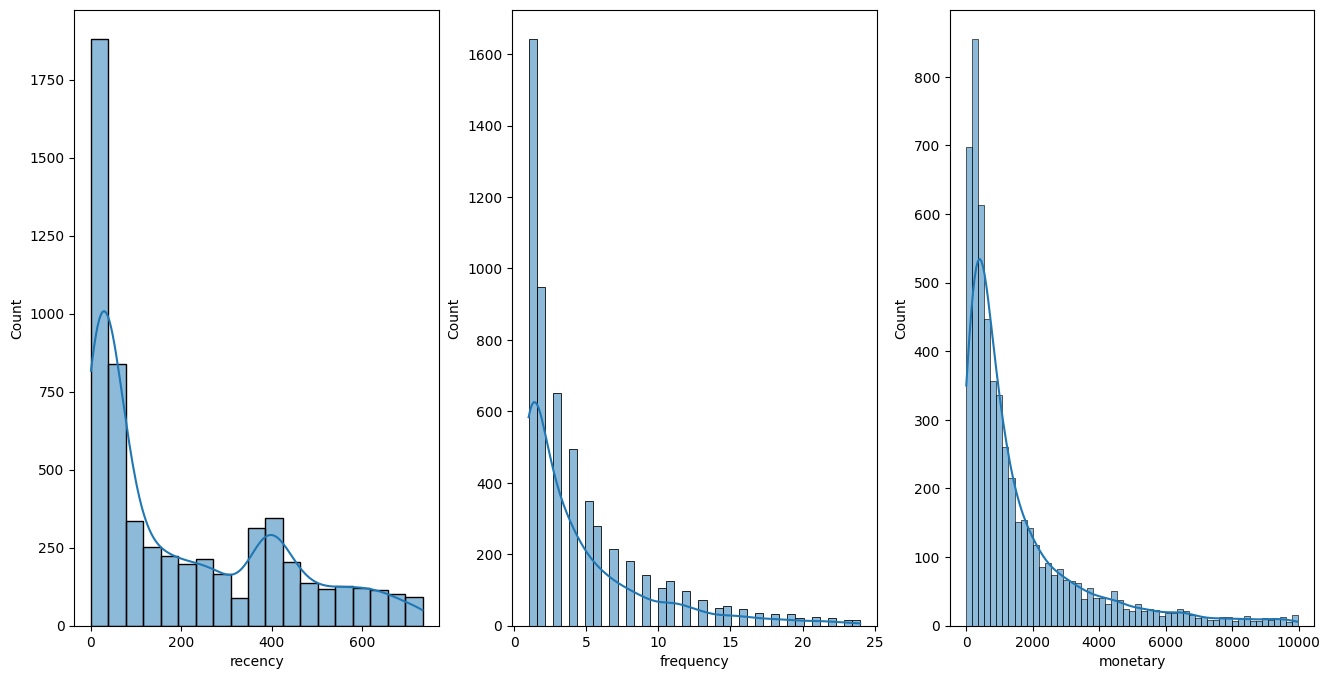

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
rfm_df = rfm.toPandas()

# Recency distribution plot
sns.histplot(rfm_df['recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_df.query('frequency < 25')['frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_df.query('monetary < 10000')['monetary'], kde=True, ax=ax[2])

In [ ]:
segments = [0.33, 0.66]

quantiles = rfm.approxQuantile(
    ["recency", "frequency", "monetary"],
    segments,
    0)
quantiles

[[40.0, 258.0], [2.0, 5.0], [460.68, 1565.59]]

In [ ]:
# Calculate R,F,M scores considering 3 quantiles

rfm_scores = (rfm
    .withColumn("R_Score",
                F.when(F.col("recency") < quantiles[0][0], F.lit(1))
                 .when(F.col("recency") < quantiles[0][1], F.lit(2))
                 .otherwise(F.lit(3)))
    .withColumn("F_Score",
                F.when(F.col("frequency") < quantiles[1][0], F.lit(3))
                 .when(F.col("frequency") < quantiles[1][1], F.lit(2))
                 .otherwise(F.lit(1)))
    .withColumn("M_Score",
                F.when(F.col("monetary") < quantiles[2][0], F.lit(3))
                 .when(F.col("monetary") < quantiles[2][1], F.lit(2))
                 .otherwise(F.lit(1))))

In [ ]:
# Aggregate RFM scores
rfm_agg_scores = (
    rfm_scores
    .withColumn("RFM_Score", F.col("R_Score") + F.col("F_Score") + F.col("M_Score"))
    .withColumn("RFM_ScoreGroup", F.concat(F.col("R_Score").cast(StringType()), F.col("F_Score").cast(StringType()), F.col("M_Score").cast(StringType())))
)

rfm_agg_scores.show(5)

+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+
|customer_id|recency|frequency|monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup|
+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+
|      13623|     25|       10| 2566.49|      1|      1|      1|        3|           111|
|      17679|     47|        7| 3577.61|      2|      1|      1|        4|           211|
|      17389|      9|       58| 51347.9|      1|      1|      1|        3|           111|
|      18051|    629|        7| 2282.28|      3|      1|      1|        5|           311|
|      13289|    718|        1|  307.95|      3|      3|      3|        9|           333|
+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+
only showing top 5 rows



In [ ]:
df_rfm_agg_scores = rfm_agg_scores.toPandas()
df_rfm_agg_scores.shape

(5863, 9)

<Axes: xlabel='RFM_ScoreGroup', ylabel='count'>

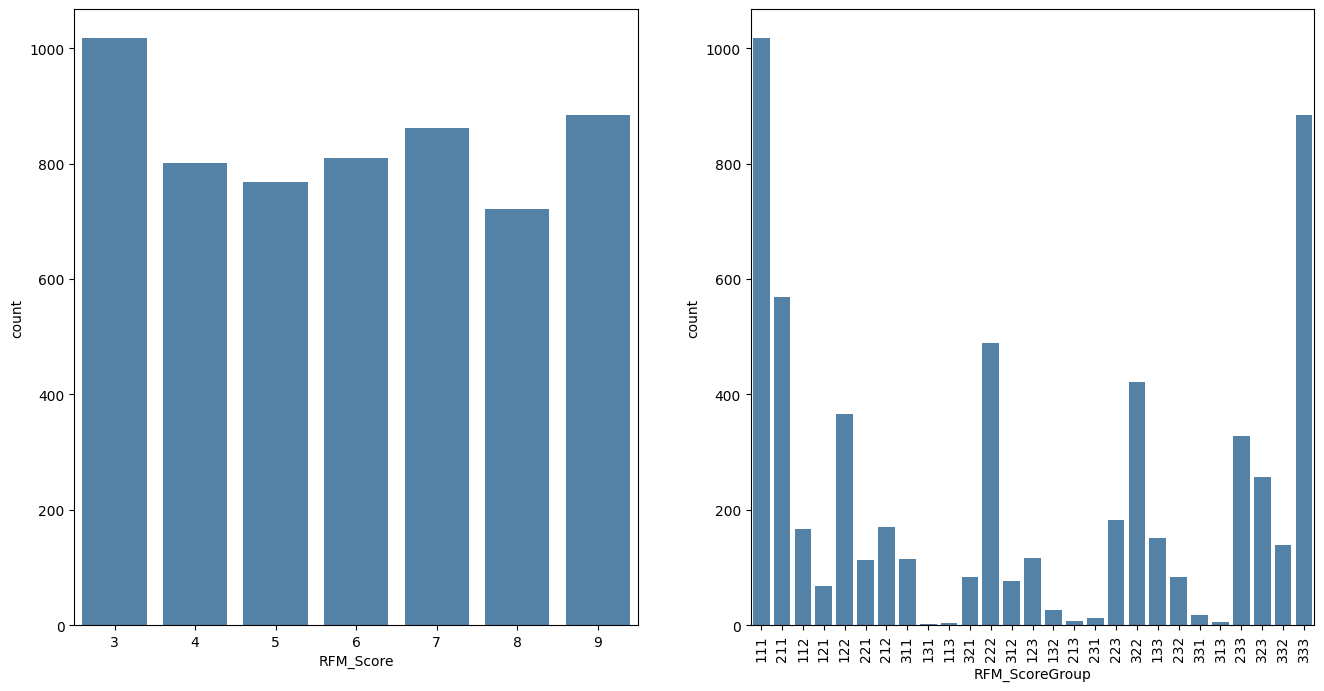

In [ ]:
df_rfm_agg_scores = df_rfm_agg_scores.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.xticks(rotation=90)
sns.countplot(x="RFM_Score", data=df_rfm_agg_scores,
              color='steelblue', ax=ax[0])
sns.countplot(x="RFM_ScoreGroup", data=df_rfm_agg_scores,
              color='steelblue', ax=ax[1])

In [ ]:
# Identify the three segments again based on RFMScore (33% in each segment)
segments = [0.33, 0.66]
quantiles = rfm_agg_scores.approxQuantile("RFM_Score", segments, 0)

In [ ]:
# Assign loyalty level to each customer
loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn("Loyalty",
                F.when((F.col("RFM_Score") <= quantiles[0]), F.lit(loyalty_level[0]))
                 .when((F.col("RFM_Score") <= quantiles[1]), F.lit(loyalty_level[1]))
                 .otherwise(F.lit(loyalty_level[2]))))
rfm_loyalty.show(5)

+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+--------+
|customer_id|recency|frequency|monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup| Loyalty|
+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+--------+
|      13623|     25|       10| 2566.49|      1|      1|      1|        3|           111|Platinum|
|      17679|     47|        7| 3577.61|      2|      1|      1|        4|           211|Platinum|
|      17389|      9|       58| 51347.9|      1|      1|      1|        3|           111|Platinum|
|      18051|    629|        7| 2282.28|      3|      1|      1|        5|           311|Platinum|
|      13289|    718|        1|  307.95|      3|      3|      3|        9|           333|  Silver|
+-----------+-------+---------+--------+-------+-------+-------+---------+--------------+--------+
only showing top 5 rows



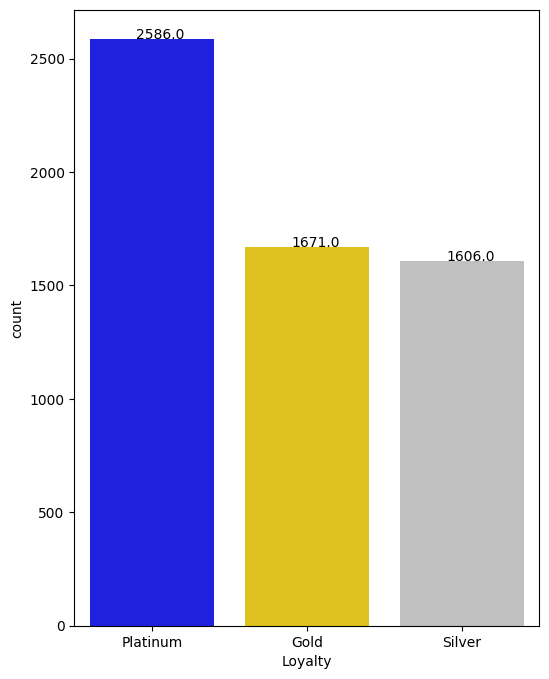

In [ ]:
# inspect our loyalty segmentation
df_rfm_loyalty = rfm_loyalty.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
loyalty_colors = {
    "Gold": "#FFD700",  # Gold
    "Platinum": "blue",  # Platinum
    "Silver": "#C0C0C0"  # Silver
}
sns.countplot(x="Loyalty", data=df_rfm_loyalty,palette=loyalty_colors)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

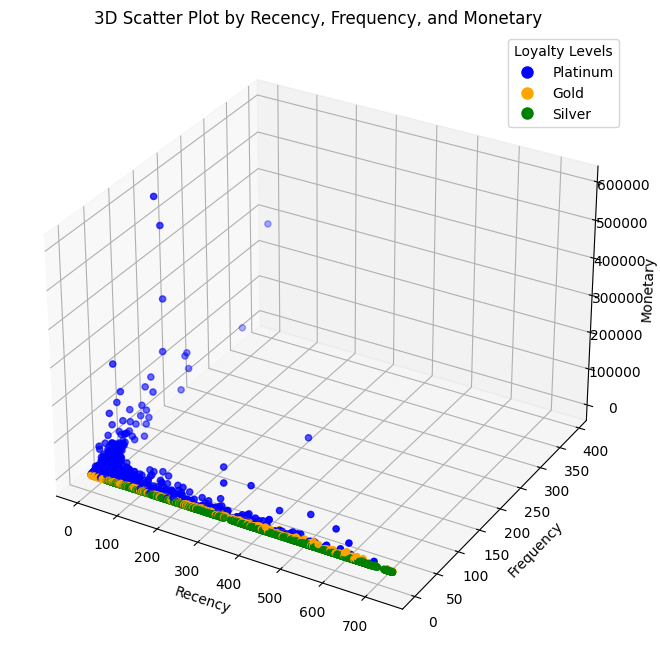

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a dictionary to map loyalty levels to colors
loyalty_colors = {'Platinum': 'blue', 'Gold': 'orange', 'Silver': 'green'}

# Scatter plot for 'Recency', 'Frequency', and 'Monetary'
scatter = ax.scatter(
    df_rfm_loyalty['recency'],
    df_rfm_loyalty['frequency'],
    df_rfm_loyalty['monetary'],
    c=df_rfm_loyalty['Loyalty'].apply(lambda x: loyalty_colors[x]),  # Apply the color mapping
    label=df_rfm_loyalty['Loyalty']
)

# Create custom legends for the loyalty categories
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=val, markersize=10)
                   for key, val in loyalty_colors.items()]
ax.legend(handles=legend_elements, title="Loyalty Levels")

# Labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot by Recency, Frequency, and Monetary')

plt.show()

<Axes: xlabel='frequency', ylabel='monetary'>

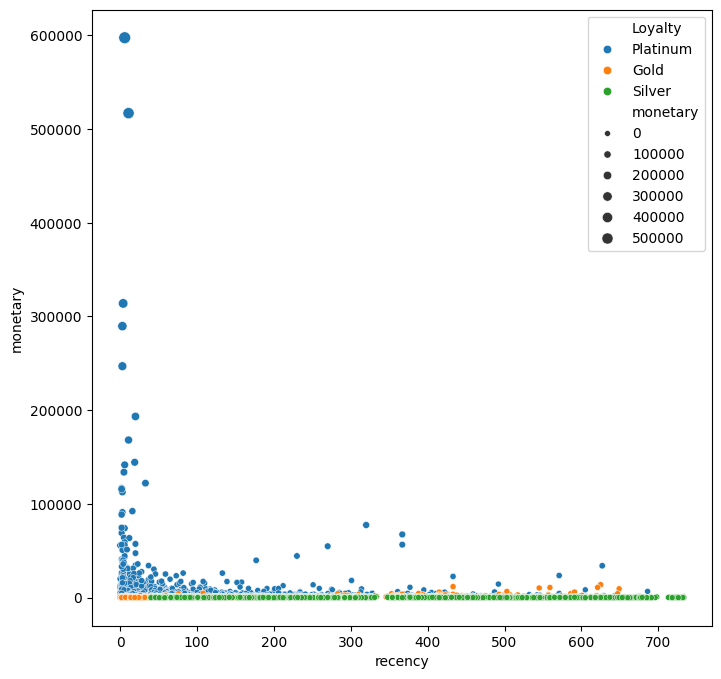

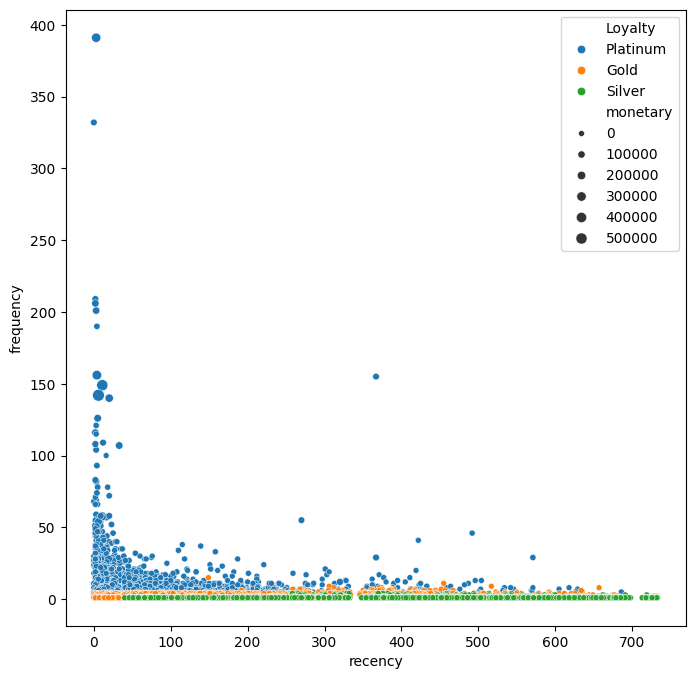

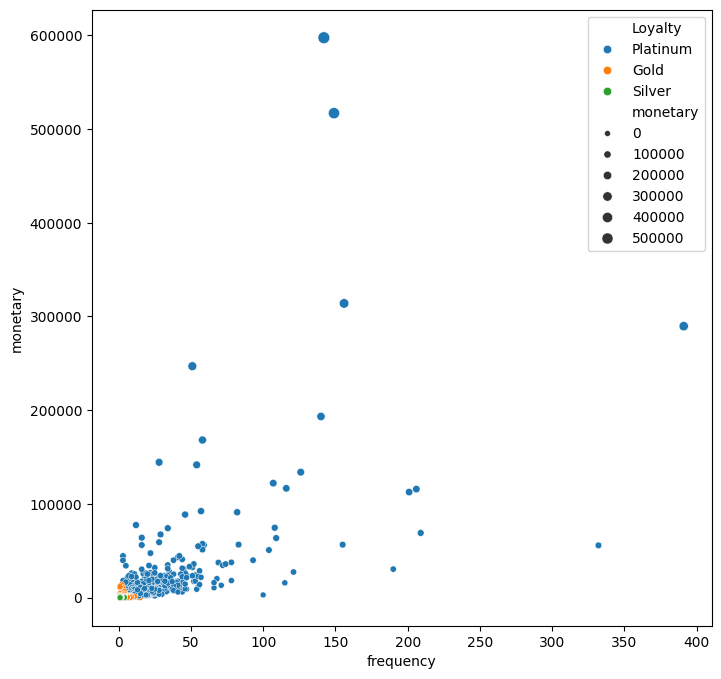

In [ ]:
# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='recency', y='monetary', data=df_rfm_loyalty, hue='Loyalty', size='monetary')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='recency', y='frequency', data=df_rfm_loyalty, hue='Loyalty', size='monetary')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(y='monetary', x='frequency', data=df_rfm_loyalty, hue='Loyalty', size='monetary')

Clustering via KMeans

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("RFM Segmentation").getOrCreate()
# Load your data here
from pyspark.ml.feature import VectorAssembler, StandardScaler

feature_cols = ['recency', 'frequency', 'monetary']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

k = 3  # This is an example; replace it with your optimal K value
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster', k=k)
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Fit the model and predict
model = pipeline.fit(rfm)
predictions = model.transform(rfm)
predictions.select('recency', 'frequency', 'monetary', 'cluster').show()

+-------+---------+--------+-------+
|recency|frequency|monetary|cluster|
+-------+---------+--------+-------+
|     25|       10| 2566.49|      1|
|     47|        7| 3577.61|      1|
|      9|       58| 51347.9|      1|
|    629|        7| 2282.28|      0|
|    718|        1|  307.95|      0|
|    459|        4|  390.56|      0|
|     11|       15| 9445.51|      1|
|     66|        3| 1301.78|      1|
|    625|        1|  322.69|      0|
|    325|        5|  492.88|      0|
|     18|        6| 3364.59|      1|
|    175|        7| 1128.44|      1|
|    101|       11| 3614.34|      1|
|    524|        1|  219.35|      0|
|     54|        5|  946.59|      1|
|    275|        3|  613.75|      0|
|     14|        2|  613.69|      1|
|     26|        3|   930.1|      1|
|    411|        1|   651.4|      0|
|     45|        6| 1084.43|      1|
+-------+---------+--------+-------+
only showing top 20 rows



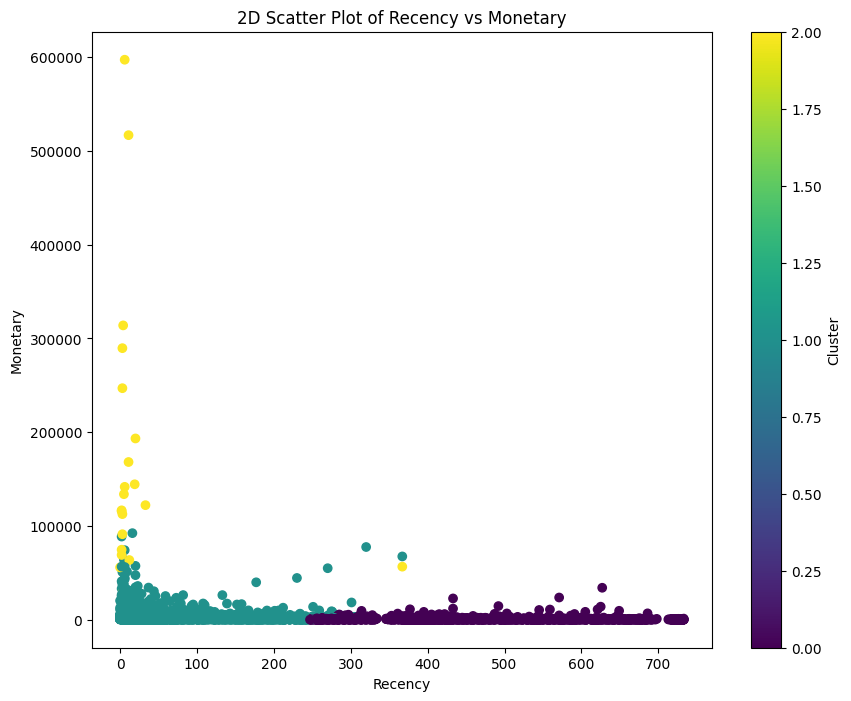

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame with predictions to Pandas DataFrame
# 'predictions' is the DataFrame obtained from the KMeans model with an added 'prediction' column
predictions_pd = predictions.toPandas()

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(predictions_pd['recency'], predictions_pd['monetary'], c=predictions_pd['cluster'], cmap='viridis')
plt.title('2D Scatter Plot of Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster')
plt.show()


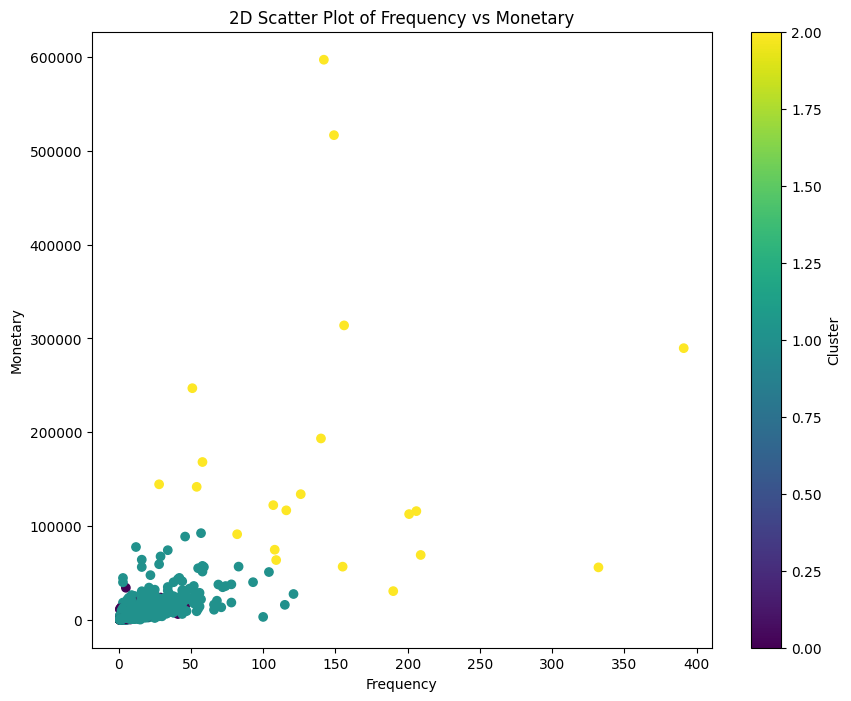

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(predictions_pd['frequency'], predictions_pd['monetary'], c=predictions_pd['cluster'], cmap='viridis')
plt.title('2D Scatter Plot of Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster')
plt.show()

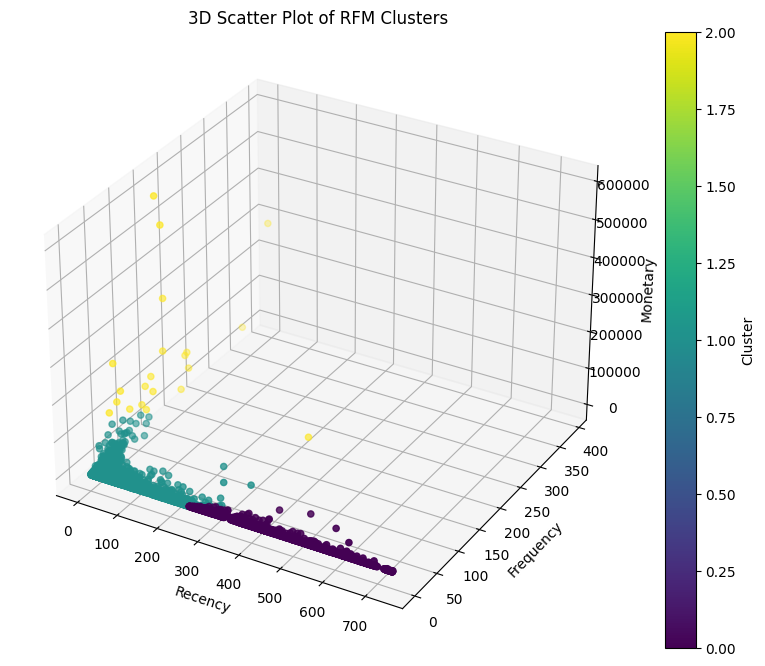

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(predictions_pd['recency'], predictions_pd['frequency'], predictions_pd['monetary'], c=predictions_pd['cluster'], cmap='viridis')

# Labels and title
ax.set_title('3D Scatter Plot of RFM Clusters')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Legend
plt.colorbar(sc, label='Cluster')

plt.show()
